<center> <b><h1>CHESS LENS</h1></b><br>
<b><h2>Team BSB64</h2></b></center>

In [1]:
import sys
sys.path.append('./utils')

import os

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import occupancy_detector as od
import chessboard_processor as cbd
import detector as md
import visualizer

## Preprocess the Chessboard

In [4]:
cbd.process_chessboard("images/board/test08.jpeg","images/demo5/","box",True)

QSocketNotifier: Can only be used with threads started with QThread


Move detected or initial frame


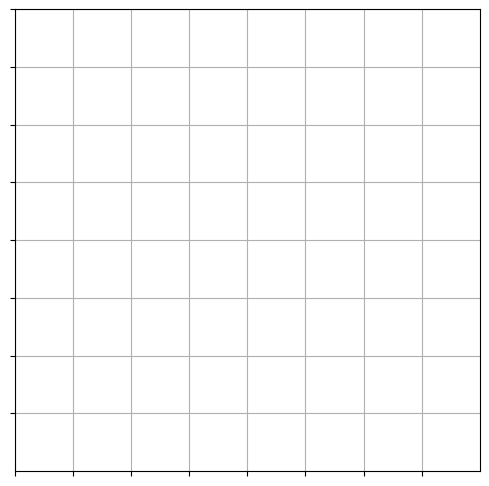

ValueError: Not enough lines for reliable board detection

In [5]:
from copy import deepcopy
import cv2
import occupancy_detector as od
import chessboard_processor as cbd
import detector as md
import visualizer
import time

# Video source: use 0 for webcam or a filepath for video
video_source = "videos/ronu_darpan_trial.mp4"  # Change this to your video path or use 0 for webcam
cap = cv2.VideoCapture(video_source)

prev_board_state = None

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Resize frame if needed for processing speed
    resized_frame = cv2.resize(frame, (800, 800))

    # Process the frame using the chessboard processor
    try:
        board_state = cbd.process_chessboard_from_frame(resized_frame)
    except Exception as e:
        print(f"Error processing frame: {e}")
        continue

    # Compare with previous board state to detect a move
    if prev_board_state is None or board_state != prev_board_state:
        print("Move detected or initial frame")
        visualizer.display_board_state(board_state)
        prev_board_state = deepcopy(board_state)
        
        cbd.process_chessboard_from_frame(board_state,"images/demo7/","box",True)

    # Display the current frame
    cv2.imshow('Chessboard Detection', resized_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


## Checking the ACCURACY of OCCUPANCY Detector

In [5]:
import os
import cv2
import numpy as np
from sklearn.metrics import accuracy_score

# === Rule-based occupancy detector ===
def is_occupied(img, std_thresh, edge_thresh):
    std_dev = np.std(img)
    edges = cv2.Canny(img, edge_thresh // 2, edge_thresh)
    edge_density = np.sum(edges > 0) / img.size
    return std_dev > std_thresh and edge_density > 0.02

# === Load data and actual labels from filenames ===
folder = "images/demo5"
images = []
actual_labels = []
filenames = []

for filename in os.listdir(folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        file_path = os.path.join(folder, filename)
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        images.append(img)
        actual_labels.append(1 if "true" in filename else 0)
        filenames.append(filename)

# === Try various combinations of thresholds ===
best_acc = 0
best_params = (0, 0)
best_predictions = []

print("Trying different thresholds...")
for std_thresh in range(0, 1000, 5):
    for edge_thresh in range(0, 2000, 10):
        predicted_labels = [
            1 if is_occupied(img, std_thresh, edge_thresh) else 0
            for img in images
        ]
        acc = accuracy_score(actual_labels, predicted_labels)
        
        if acc > best_acc:
            best_acc = acc
            best_params = (std_thresh, edge_thresh)
            best_predictions = predicted_labels.copy()

# === Output best result summary ===
print(f"\nBest Accuracy: {best_acc:.4f}")
print(f"Optimal std_thresh: {best_params[0]}, edge_thresh: {best_params[1]}")
print("\nStatus\t\tActual\tPredicted\tFilename")

for actual, predicted, fname in zip(actual_labels, best_predictions, filenames):
    status = "Correct" if actual == predicted else "Wrong"
    print(f"{status}\t\t{actual}\t{predicted}\t\t{fname}")



Trying different thresholds...

Best Accuracy: 0.8125
Optimal std_thresh: 40, edge_thresh: 590

Status		Actual	Predicted	Filename
Correct		1	1		box-3-true.jpg
Correct		1	1		box-11-true.jpg
Wrong		0	1		box-46.jpg
Correct		1	1		box-61-true.jpg
Correct		0	0		box-31.jpg
Correct		0	0		box-21.jpg
Correct		0	0		box-20.jpg
Correct		0	0		box-16.jpg
Correct		0	0		box-29.jpg
Correct		1	1		box-54-true.jpg
Correct		1	1		box-58-true.jpg
Correct		1	1		box-51-true.jpg
Correct		1	1		box-9-true.jpg
Correct		1	1		box-12-true.jpg
Correct		0	0		box-33.jpg
Correct		0	0		box-41.jpg
Correct		1	1		box-10-true.jpg
Correct		0	0		box-26.jpg
Correct		1	1		box-5-true.jpg
Correct		0	0		box-43.jpg
Correct		1	1		box-2-true.jpg
Wrong		0	1		box-39.jpg
Wrong		1	0		box-63-true.jpg
Correct		1	1		box-15-true.jpg
Correct		1	1		box-55-true.jpg
Correct		0	0		box-32.jpg
Correct		0	0		box-42.jpg
Correct		1	1		box-7-true.jpg
Correct		1	1		box-53-true.jpg
Correct		1	1		box-13-true.jpg
Correct		1	1		box-56-true.jpg
Wrong		1	0		box-

In [15]:
TP = 0 # True Positives: Actual 1 and Pred 1
FP = 0 # False Positives: Actual 0 but Pred 1
FN = 0 # False Negatives: Actual 1 but Pred 0
TN = 0 # True Negatives: Actual 0 and Pred 0

In [16]:
count = 0
for i in actual_labels:
    count+=1 if i==1 else 0

print(count)

32


In [17]:
len(actual_labels)

64

In [18]:
count = 0
# for i in predicted_labels:
for i in best_predictions:
    count+=1 if i==1 else 0

print(count)

32


In [19]:
for i in range(64):
    TP+=1 if actual_labels[i]==1 and best_predictions[i]==1 else 0
    FP+=1 if actual_labels[i]==0 and best_predictions[i]==1 else 0
    FN+=1 if actual_labels[i]==1 and best_predictions[i]==0 else 0
    TN+=1 if actual_labels[i]==0 and best_predictions[i]==0 else 0

In [20]:
from sklearn.metrics import accuracy_score
y_pred = [0, 2, 1, 3]
y_true = [0, 1, 2, 3]
accuracy_score(actual_labels, best_predictions)

0.8125

In [21]:
print(f"Accuracy = {(TP+TN)/(TP+TN+FN+FP)}")

Accuracy = 0.8125


For now, the board is at the initial position. With every next move, the board's position will change, and thus will the board matrix. Also, the board matrix needs to be converted to FEN for the UI.

In [22]:
board_matrix = [
    ["r", "n", "b", "q", "k", "b", "n", "r"],
    ["p"] * 8,
    [""] * 8,
    [""] * 8,
    [""] * 8,
    [""] * 8,
    ["P"] * 8,
    ["R", "N", "B", "Q", "K", "B", "N", "R"]
]

In [23]:
def board_matrix_to_fen(board_matrix):
    fen_rows = []
    
    for row in board_matrix:
        fen_row = ""
        empty_count = 0
        
        for cell in row:
            if cell == "":
                empty_count += 1
            else:
                if empty_count > 0:
                    fen_row += str(empty_count)
                    empty_count = 0
                fen_row += cell
        if empty_count > 0:
            fen_row += str(empty_count)
        
        fen_rows.append(fen_row)
    
    # Join all rows with "/" and add standard placeholders for FEN (assuming starting position)
    fen_position = "/".join(fen_rows)
    fen = f"{fen_position} w KQkq - 0 1"
    return fen


In [24]:
print(board_matrix_to_fen(board_matrix))

rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1
